# Phishbuster Starts Here

### Importing libraries

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

# For text extraction
from sklearn.feature_extraction.text import TfidfVectorizer 

# To create a full ML pipeline
from sklearn.pipeline import Pipeline

# For model evaluation
from sklearn.metrics import classification_report

# For combining different fature preprocessing steps
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier


### Loading the dataset

In [2]:
data = pd.read_csv("data.csv")



### Features and target

In [3]:
x = data[["Message_Text"]]

y = data.Type

### Encode Target ( Phising = 1, Legitimate = 0)

In [4]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

### Define features group

In [5]:

# ### List of features
# numeric_features = ["Message_Length", "Num_Links", 
#                     "Suspicious_Keyword_Count", "Has_Link", "Has_Urgency_Keywords"]


# ### Lists of features
# categorical_features = ["Platform", "Sender"]

## Single features
text_feature = "Message_Text"

### Numeric Transformer

In [6]:
numeric_transformer = StandardScaler()

### Categorical Transformer

In [7]:
categorical_transformer = OneHotEncoder()

### Text Transformer


In [8]:
text_transformer = TfidfVectorizer()

### ColumnTransformer combines preprocessing for all feature types as 

In [9]:
preprocessor = ColumnTransformer(
    transformers= [
        # ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features),
        ("text", text_transformer, text_feature)
    ]
)

### Build Pipeline with model

##### The pipeline first applies preprocessing, then trains on XGboost classfier

In [10]:
clf = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        #  No of trees
        n_estimators = 300,

        # Step size for boosting upates
        learning_rate = 0.1,

        #  Maxmim no. of depts
        max_depth = 6,

        # Fraction of training data to sample for each tree
        subsample = 0.8,

        #  Fraction of features to sample per tree
        colsample_bytree = 0.8,

        # Reporducibility
        random_state= 42,

        # Evaluation merics for binary classification
        eval_metric = "logloss"
    ))
])

### Splitting and training testing data

In [11]:
# Stratigy ensures the same ratio of phising vs legitimate in both train and test split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state= 42, stratify= y)


In [12]:
x_train.shape

(16000, 1)

In [13]:
y_train.shape

(16000,)

### Model Definition and Fitting

In [14]:
### Using the concept of Pipeline

In [15]:
clf.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Predicting based on Message Input

In [16]:
phishbuster = clf.predict(x_test)
phishbuster





array([1, 0, 0, ..., 1, 1, 1], shape=(4000,))

### Inverse Transformations

In [17]:
phishbuster_labels = label_encoder.inverse_transform(y)

phishbuster_labels

array(['Legit', 'Phishing', 'Legit', ..., 'Phishing', 'Phishing', 'Legit'],
      shape=(20000,), dtype=object)

### converting phishbuster into dataframe

In [18]:
phishbuster_df = pd.DataFrame(phishbuster_labels)

In [19]:
phishbuster.shape

(4000,)

In [20]:
phishbuster.size

4000

In [21]:
print(type(phishbuster))

<class 'numpy.ndarray'>


### Message Inputing and checking whether message is phising or legit 

In [22]:

input_msg = str(input("Enter the message:"))

# Message_Text is the column used and below   we define dictonary in dataframe with key as Message_Text 
# whose value is our input we provide now  the model will predict how well our model works

df_input = pd.DataFrame({"Message_Text" : [input_msg]})

# Prediction

pred = clf.predict(df_input)

pred_label = label_encoder.inverse_transform(pred)

print(f"Prediction: {pred_label[0]}")

Prediction: Legit


### Evaluation Part

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


accuracy = accuracy_score(phishbuster, y_test)
print(f"The accuracy score of the model is: {accuracy:.2%}")

f1 = f1_score(phishbuster, y_test)
print(f"The f1 score is as: {f1:.2%}")

confusion = confusion_matrix(phishbuster, y_test)
print("The confusion score as:", confusion)

The accuracy score of the model is: 100.00%
The f1 score is as: 100.00%
The confusion score as: [[1997    0]
 [   0 2003]]


### Visualizations Techniques

### Class Distribution of Phising and Legit Data using Countplot

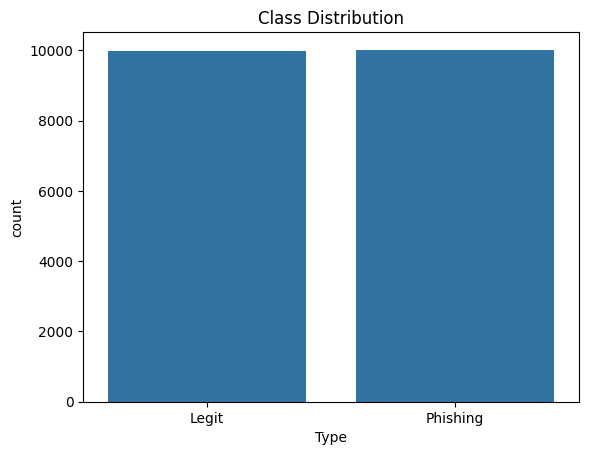

In [36]:
#  Importing and drawing the tree diagram
import seaborn as sbn

import matplotlib.pyplot as plt

sbn.countplot(x= data['Type'])
plt.title("Class Distribution")

plt.show()

### Phising Words Frequently Used and Legitimate Ones Too using Word Cloud

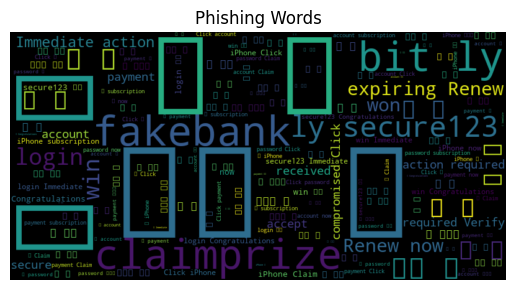

In [46]:
from wordcloud import WordCloud

phishing_text = " ".join(data[data['Type']=='Phishing']['Message_Text'])
legit_text = " ".join(data[data['Type']=='Legitimate']['Message_Text'])

WordCloud(width=800, height=400).generate(phishing_text)
plt.title("Phishing Words")
plt.imshow(WordCloud(width=800, height=400).generate(phishing_text), interpolation='bilinear')
plt.axis('off')
plt.show()


### Depiciting the confusion_matrix using Heatmap

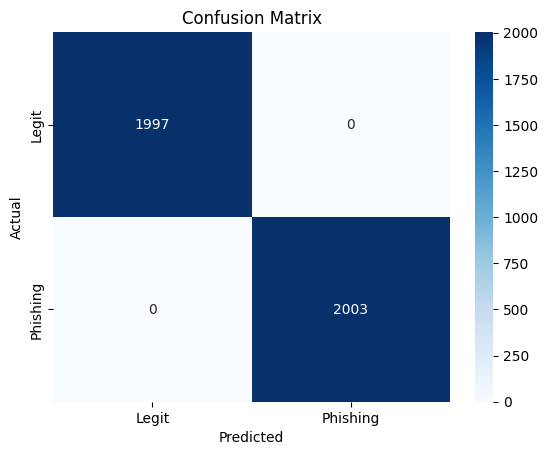

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Prediction Probability Distributon using Histogram

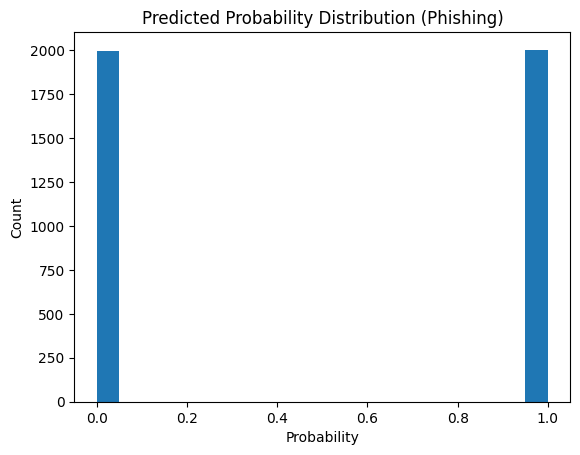

In [51]:
y_prob = clf.predict_proba(x_test)[:,1]
plt.hist(y_prob, bins=20)
plt.title("Predicted Probability Distribution (Phishing)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


### Message Length by Classes 

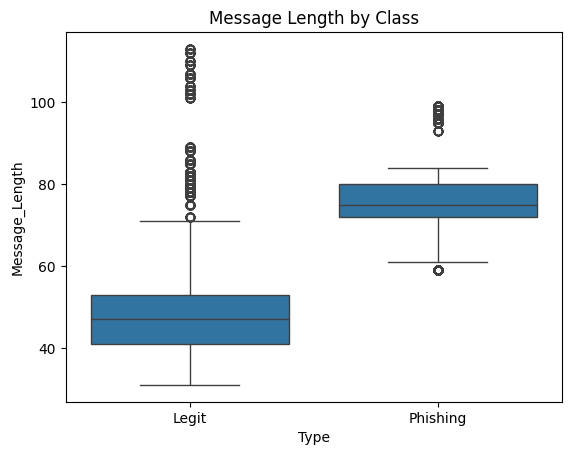

In [ ]:

sns.boxplot(x='Message_Length', y='Message_Length', data=data)
plt.title("Message Length by Class")
plt.show()
